In [103]:
# Training settings
batch_size = 64
epochs = 40
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'

In [104]:
import torch
from Vit.efficient import ViT
from Vit.simple_vit import SimpleViT
from linformer import Linformer

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)
#model = ViT(
#    image_size = 384,
#    patch_size = 32,
#    num_classes = 1000,
#    dim = 1024,
#    transformer=efficient_transformer,
#    channels=3,
#)
model = SimpleViT(
    image_size = 384,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
)
model.to(device)
efficient_transformer.to(device)

Linformer(
  (net): SequentialSequence(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): LinformerSelfAttention(
            (to_q): Linear(in_features=128, out_features=128, bias=False)
            (to_k): Linear(in_features=128, out_features=128, bias=False)
            (to_v): Linear(in_features=128, out_features=128, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_out): Linear(in_features=128, out_features=128, bias=True)
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (w1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (dropout): Dropout(p=0.0, inplace=False)
            (w2): Linear(in_features=512, out_features=128, bias=True)
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): Mo

In [105]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [106]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)


In [107]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


In [108]:
import torchvision
from torch.utils.data import random_split

dataset = torchvision.datasets.CIFAR100('../data',train=True,transform=train_transforms,download=False)
trainset, valset = random_split(dataset,[0.7,0.3])
valset.transform = val_transforms

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size)

testset = torchvision.datasets.CIFAR100('../data',train=False,transform=test_transforms,download=False)
testsetloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

classes = testset.classes

#train_list = glob.glob(os.path.join('../data/catsNdogs/train/','*.jpg'))
#test_list = glob.glob(os.path.join('../data/catsNdogs/test/', '*.jpg'))
#labels = [path.split('/')[-1].split('.')[0] for path in train_list]
#test_labels = [path.split('/')[-1].split('.')[0] for path in test_list]

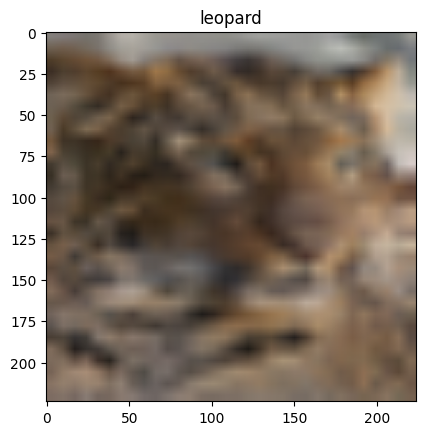

In [109]:
imgs, labels = next(iter(valloader))
plt.imshow(imgs[0].numpy().transpose(1,2,0))
plt.title(str(classes[labels[0].item()]))
plt.show()

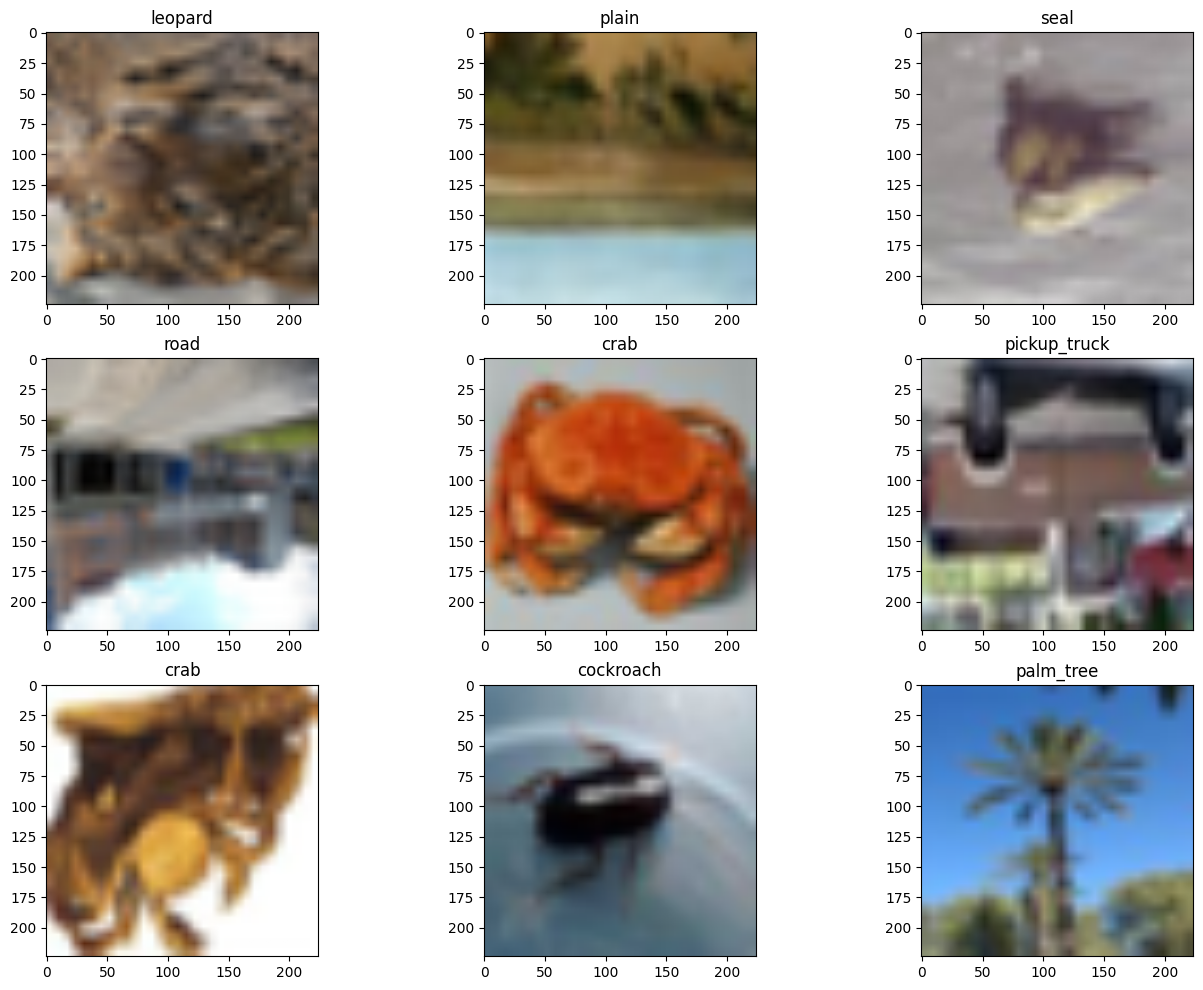

In [110]:
imgs, labels = next(iter(valloader))
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = imgs[idx].numpy().transpose(1,2,0)
    ax.set_title(str(classes[labels[idx].item()]))
    ax.imshow(img)


In [111]:
print(f"Train Data: {len(trainset)}")
print(f"Validation Data: {len(valset)}")
print(f"Test Data: {len(testset)}")

Train Data: 35000
Validation Data: 15000
Test Data: 10000


In [112]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [113]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(trainloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valloader)
            epoch_val_loss += val_loss / len(valloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 1 - loss : 4.2620 - acc: 0.0725 - val_loss : 3.7577 - val_acc: 0.1253



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.4391 - acc: 0.1745 - val_loss : 3.2461 - val_acc: 0.2090



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 3 - loss : 3.0589 - acc: 0.2399 - val_loss : 3.0149 - val_acc: 0.2520



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.8188 - acc: 0.2896 - val_loss : 2.8637 - val_acc: 0.2788



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.6260 - acc: 0.3273 - val_loss : 2.7425 - val_acc: 0.3016



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.4629 - acc: 0.3640 - val_loss : 2.6611 - val_acc: 0.3213



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.3133 - acc: 0.3956 - val_loss : 2.6042 - val_acc: 0.3324



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.1702 - acc: 0.4275 - val_loss : 2.5535 - val_acc: 0.3432



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 9 - loss : 2.0367 - acc: 0.4608 - val_loss : 2.5199 - val_acc: 0.3499



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.9123 - acc: 0.4898 - val_loss : 2.4933 - val_acc: 0.3622



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 11 - loss : 1.7843 - acc: 0.5250 - val_loss : 2.4715 - val_acc: 0.3641



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.6565 - acc: 0.5563 - val_loss : 2.4725 - val_acc: 0.3680



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 13 - loss : 1.5348 - acc: 0.5867 - val_loss : 2.4734 - val_acc: 0.3738



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 14 - loss : 1.4125 - acc: 0.6191 - val_loss : 2.4833 - val_acc: 0.3763



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 15 - loss : 1.2937 - acc: 0.6505 - val_loss : 2.4928 - val_acc: 0.3818



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 16 - loss : 1.1643 - acc: 0.6909 - val_loss : 2.5147 - val_acc: 0.3832



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 17 - loss : 1.0455 - acc: 0.7196 - val_loss : 2.5730 - val_acc: 0.3783



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.9279 - acc: 0.7562 - val_loss : 2.6349 - val_acc: 0.3693



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.8054 - acc: 0.7895 - val_loss : 2.6825 - val_acc: 0.3733



  0%|          | 0/547 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.7078 - acc: 0.8184 - val_loss : 2.7476 - val_acc: 0.3694



  0%|          | 0/547 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [116]:
torch.save(model.state_dict(),'../models/vit_cifar_20e_36a.pt')